# Plot offline quantities for et2, eta0

In [181]:
from ProfileTools import profiles
from Gaugi import load
from Gaugi.monet.utils import getColor
from Gaugi.monet.PlotFunctions import *
from Gaugi.monet.TAxisFunctions import *
from Gaugi.monet.AtlasStyle import *
from ROOT import TCanvas, TH1F, TH1I
from ROOT import kRed, kBlue, kBlack,TLine,kBird, kOrange,kGray, kYellow, kViolet, kGreen, kAzure
from pprint import pprint
import array
import numpy as np
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
SetAtlasStyle()
GeV=1000.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Applying ATLAS style settings...


In [6]:
path = '/Volumes/castor/cern_data/files/Zee/mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17/'
path+= 'mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17_et{ET}_eta{ETA}.npz'
paths = [[ path.format(ET=et,ETA=eta) for eta in range(5)] for et in range(5)]  

In [7]:
def merge_data( paths ):
    data = None
    features = None
    target = None
    for et in range(5):
        for eta in range(5):
            raw = load(paths[et][eta])
            if data is None:
                data = raw['data']
                target = raw['target']
                features = raw['features']
            else:
                data = np.concatenate((data, raw['data']),axis=0)
                target = np.concatenate((target, raw['target']),axis=0)
    return data, target, features

data,target,features = merge_data(paths)
features = features.tolist()

In [27]:
values = {}

## Get all standard shower shapes:

In [29]:
ss_keys = [
             'rhad1',
             'rhad',
             'f3',
             'weta2',
             'rphi',
             'reta',
             'wtots1',
             'eratio',
             'f1'
            ]
et = data[:, features.index('et')]
eta = data[:, features.index('eta')]
sgn_index = np.where((target==1) & (et>=25*GeV) & (et<30*GeV) & (abs(eta) < 0.6) )
bkg_index = np.where((target!=1) & (et>=25*GeV) & (et<30*GeV) & (abs(eta) < 0.6) )


for key in ss_keys:
    values[key+'_sgn'] = data[sgn_index, features.index(key)].flatten()
    values[key+'_bkg'] = data[bkg_index, features.index(key)].flatten()

## Get all track variables:

In [30]:
 track_keys = [
                 'numberOfBLayerHits',
                 'numberOfPixelHits',
                 'numberOfTRTHits',
                 'd0',
                 'd0significance',
                 'eProbabilityHT',
                 'trans_TRT_PID',
                 'deltaEta1',
                 'deltaPhi2',
                 'deltaPhi2Rescaled',
                 'DeltaPOverP',
            ]

et = data[:, features.index('et')]
eta = data[:, features.index('eta')]
has_track = data[:, features.index('hastrack')]
sgn_index = np.where((target==1) & (et>=25*GeV) & (et<30*GeV) & (abs(eta) < 0.6) & (has_track==True) )
bkg_index = np.where((target!=1) & (et>=25*GeV) & (et<30*GeV) & (abs(eta) < 0.6) & (has_track==True))

for key in track_keys:
    values[key+'_sgn'] = data[sgn_index, features.index(key)].flatten()
    values[key+'_bkg'] = data[bkg_index, features.index(key)].flatten()

## Let's plot all variables:

In [31]:
def AddLegend(canvas, x, y, legends):
    MakeLegend( canvas,x,y,x+0.98,y+0.20,textsize=16, names=legends, option = 'f' )

In [212]:
def NormHist(hist, norm=None, removeZeros=0):
    from ROOT import TH1F
    if not norm:  norm = 1./sum(hist)
    h = TH1F(hist.GetName()+"_normalized", hist.GetTitle(), hist.GetNbinsX(), hist.GetBinLowEdge(1),
           hist.GetBinLowEdge( hist.GetNbinsX() + 1 ) )
    for bin in range(0,h.GetNbinsX()+1):
        content = hist.GetBinContent(bin)
        if not content and removeZeros:  content=removeZeros
        value = content*norm if norm else content
        h.SetBinContent(bin , value )
    return h

In [206]:
def PlotHist( values_sgn, values_bkg , xlabel, bins, xmin, xmax , y_axis_maximum=None, normalize=True):    
    def CreateHist(values, name, bins, xmin, xmax):
        h = TH1F(name, "", bins, xmin, xmax)
        w = array.array( 'd', np.ones_like(values) )
        h.FillN( len(values), array.array('d',  values.tolist()),  w)
        return h
    
    h_sgn = CreateHist(values_sgn, 'sgn', bins, xmin, xmax)
    h_bkg = CreateHist(values_bkg, 'bkg', bins, xmin, xmax)
    # Create canvas
    canvas = TCanvas('canvas','canvas',700, 500)
    if normalize:
        h_sgn = NormHist(h_sgn)
        h_bkg = NormHist(h_bkg)
    h_sgn.SetLineColor(kAzure)
    h_sgn.SetFillColor(kAzure-4)
    h_bkg.SetLineColor(kRed)
    h_bkg.SetFillColor(getColor(kRed, 0.5))
    if y_axis_maximum:
        h_sgn.SetMaximum(y_axis_maximum)
        h_bkg.SetMaximum(y_axis_maximum)
    AddHistogram(canvas,h_sgn, 'same')
    AddHistogram(canvas,h_bkg, 'same')
    FormatCanvasAxes(canvas, XLabelSize=16, YLabelSize=16, XTitleOffset=0.87, ZLabelSize=16,
                             ZTitleSize=16, YTitleOffset=1.10, ZTitleOffset=1.1)
    SetAxisLabels(canvas,xlabel, 'counts/bin (norm by counts)')
    return canvas

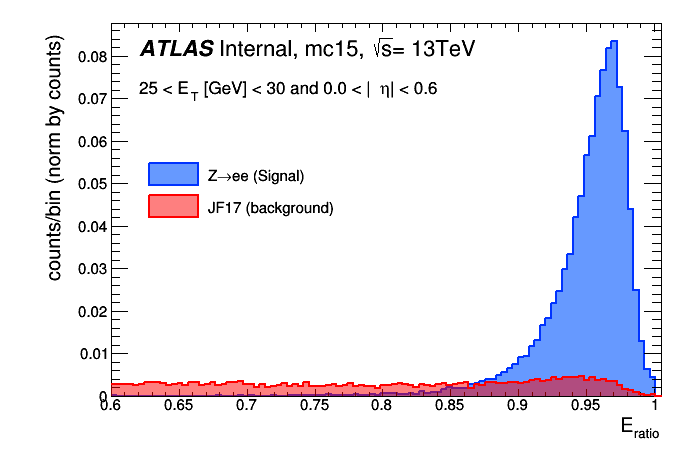

In [231]:
canvas = PlotHist(values['eratio_sgn'], values['eratio_bkg'], 'E_{ratio}', 100, 0.6, 1.005)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.2,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('eratio_et2_eta0.pdf')

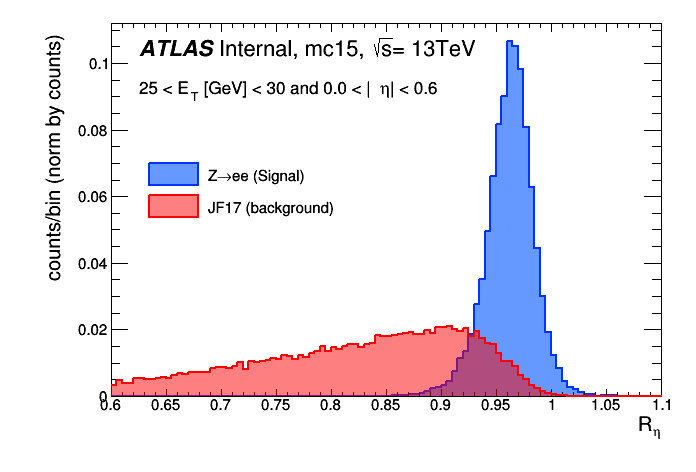

In [232]:
canvas = PlotHist(values['reta_sgn'], values['reta_bkg'], 'R_{#eta}', 100, 0.6, 1.1)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.2,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('reta_et2_eta0.pdf')

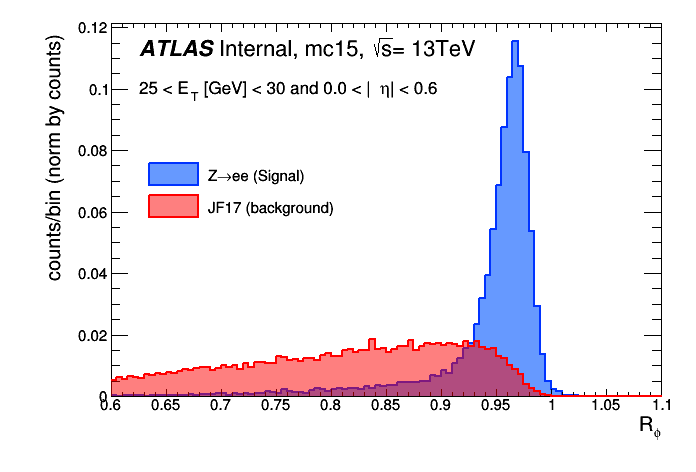

In [233]:
canvas = PlotHist(values['rphi_sgn'], values['rphi_bkg'], 'R_{#phi}', 100, 0.6, 1.1)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.2,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('rphi_et2_eta0.pdf')

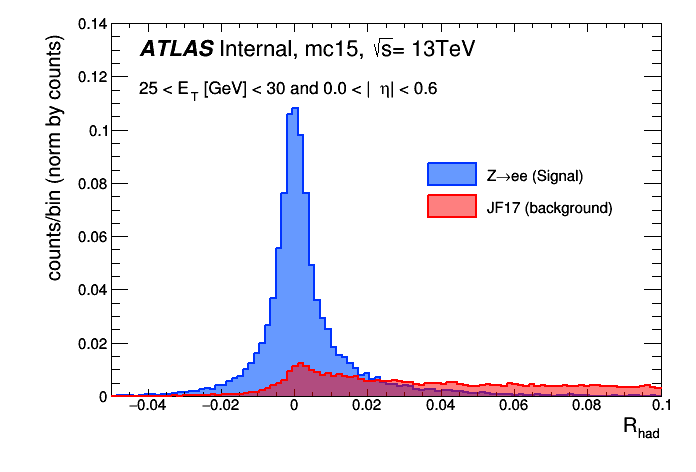

In [234]:
canvas = PlotHist(values['rhad_sgn'], values['rhad_bkg'], 'R_{had}', 100, -0.05, 0.1, 0.14)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.6,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('rhad_et2_eta0.pdf')

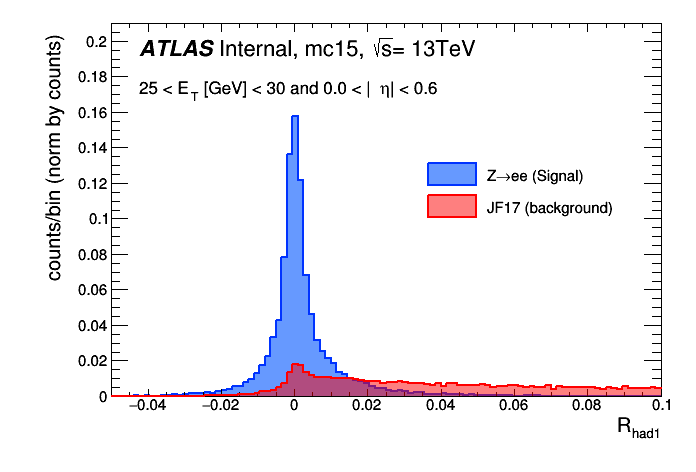

In [235]:
canvas = PlotHist(values['rhad1_sgn'], values['rhad1_bkg'], 'R_{had1}', 100, -0.05, 0.1, 0.21)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.6,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('rhad1_et2_eta0.pdf')

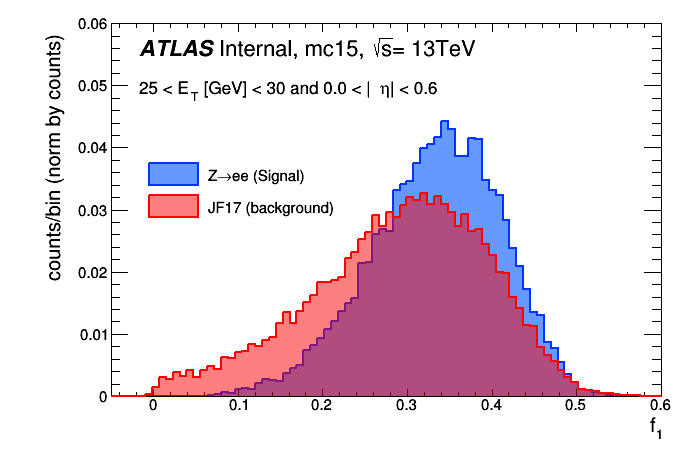

In [236]:
canvas = PlotHist(values['f1_sgn'], values['f1_bkg'], 'f_{1}', 80, -0.05, 0.6,0.06)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.2,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('f1_et2_eta0.pdf')

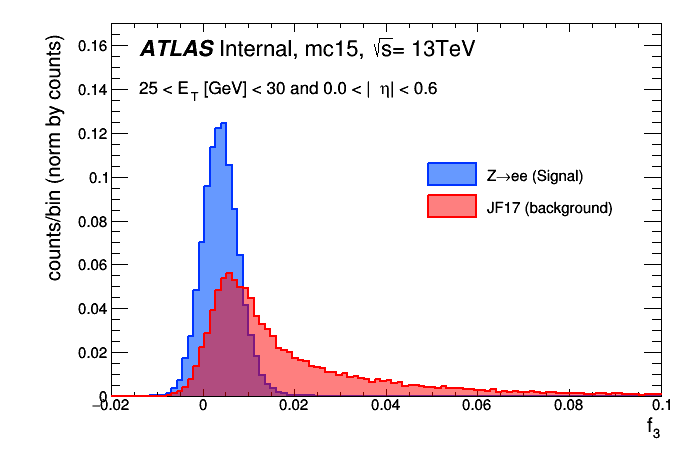

In [237]:
canvas = PlotHist(values['f3_sgn'], values['f3_bkg'], 'f_{3}', 100, -0.02, 0.1,0.17)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.6,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('f3_et2_eta0.pdf')

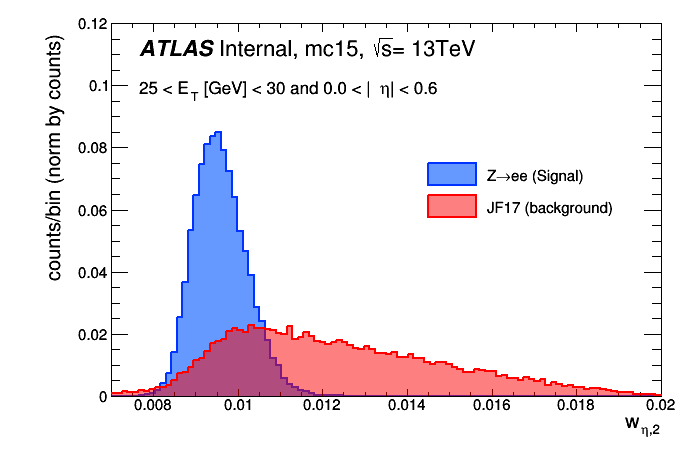

In [238]:
canvas = PlotHist(values['weta2_sgn'], values['weta2_bkg'], 'w_{#eta,2}', 100, 0.007, 0.02,0.12)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.6,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('weta2_et2_eta0.pdf')

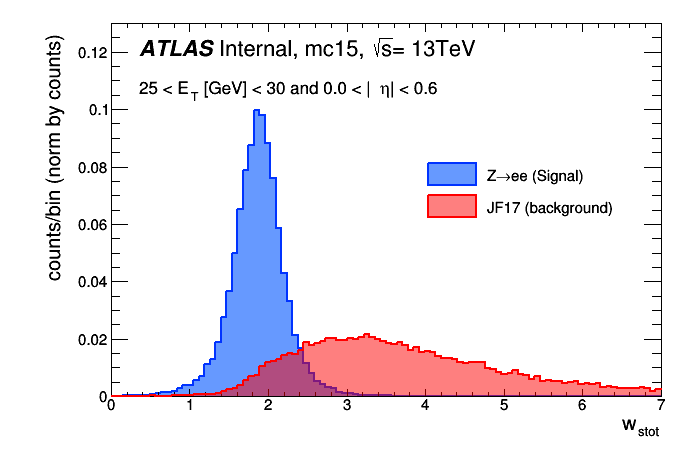

In [239]:
canvas = PlotHist(values['wtots1_sgn'], values['wtots1_bkg'], 'w_{stot}', 100, 0, 7, 0.13)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.6,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('wstot_et2_eta0.pdf')

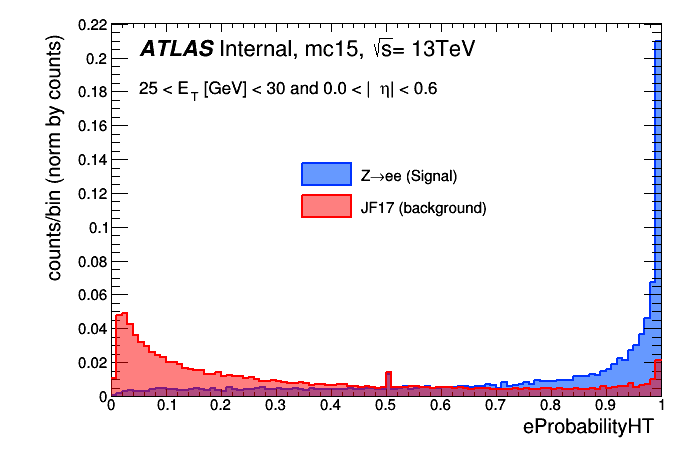

In [240]:
canvas = PlotHist(values['eProbabilityHT_sgn'], values['eProbabilityHT_bkg'], 'eProbabilityHT', 100, 0, 1)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.42,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('eProbabilityHT_et2_eta0.pdf')

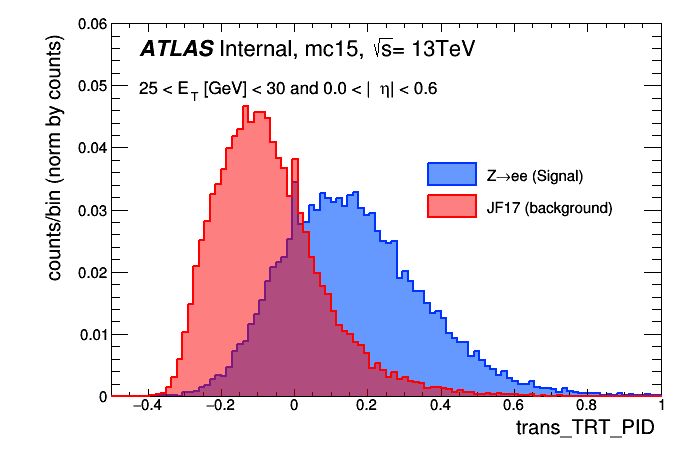

In [241]:
canvas = PlotHist(values['trans_TRT_PID_sgn'], values['trans_TRT_PID_bkg'], 'trans_TRT_PID', 100, -0.5,1, 0.06)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.6,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('trans_TRT_PID_et2_eta0.pdf')

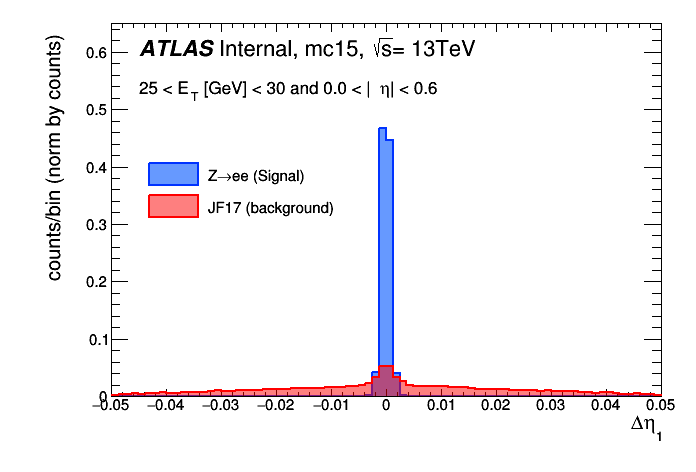

In [242]:
canvas = PlotHist(values['deltaEta1_sgn'], values['deltaEta1_bkg'], '#Delta#eta_{1}', 80, -0.05,0.05,0.65)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.2,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('deltaEta1_et2_eta0.pdf')

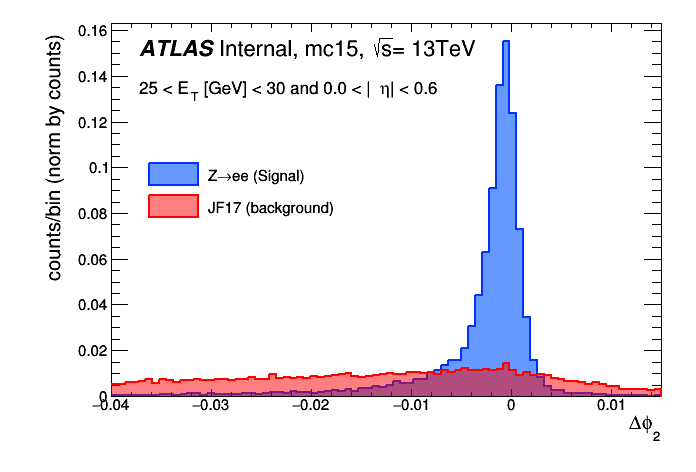

In [243]:
canvas = PlotHist(values['deltaPhi2_sgn'], values['deltaPhi2_bkg'], '#Delta#phi_{2}', 80, -0.04,0.015)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.2,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('deltaPhi2_et2_eta0.pdf')

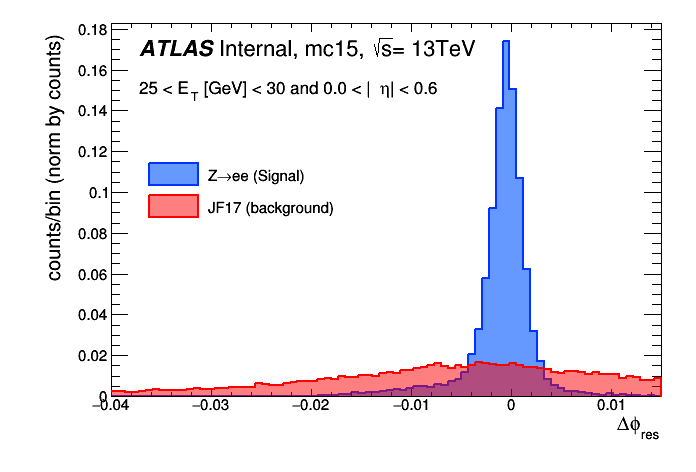

In [244]:
canvas = PlotHist(values['deltaPhi2Rescaled_sgn'], values['deltaPhi2Rescaled_bkg'], '#Delta#phi_{res}', 80, -0.04,0.015)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.2,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('deltaPhi2Rescaled_et2_eta0.pdf')

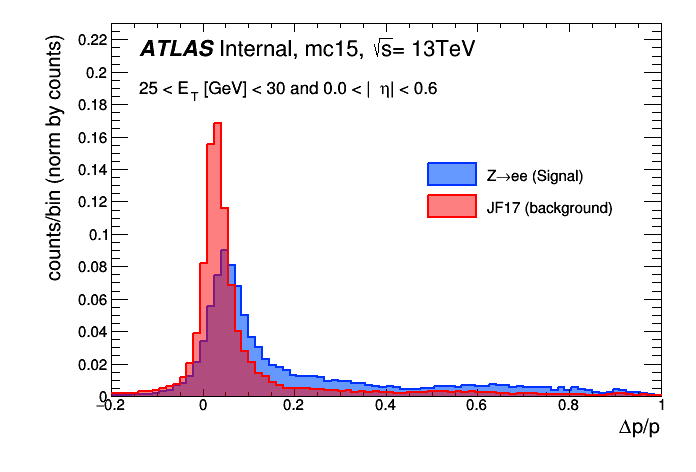

In [245]:
canvas = PlotHist(values['DeltaPOverP_sgn'], values['DeltaPOverP_bkg'], '#Deltap/p', 80, -0.2,1,0.23)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.6,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('DeltaPOverP_et2_eta0.pdf')

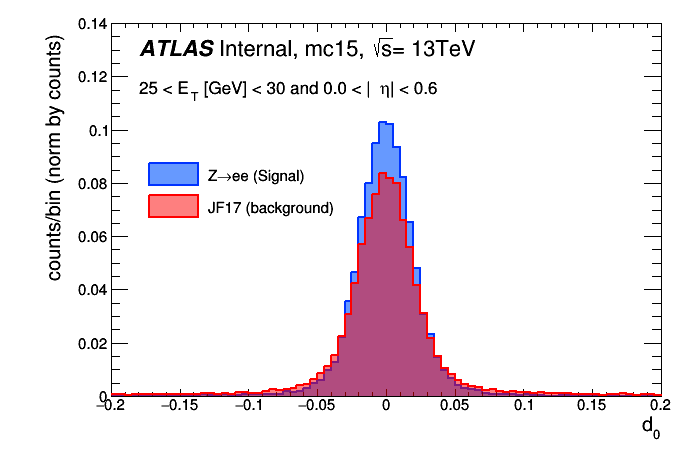

In [246]:
canvas = PlotHist(values['d0_sgn'], values['d0_bkg'], 'd_{0}', 80, -0.2,0.2,0.14)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.2,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('d0_et2_eta0.pdf')

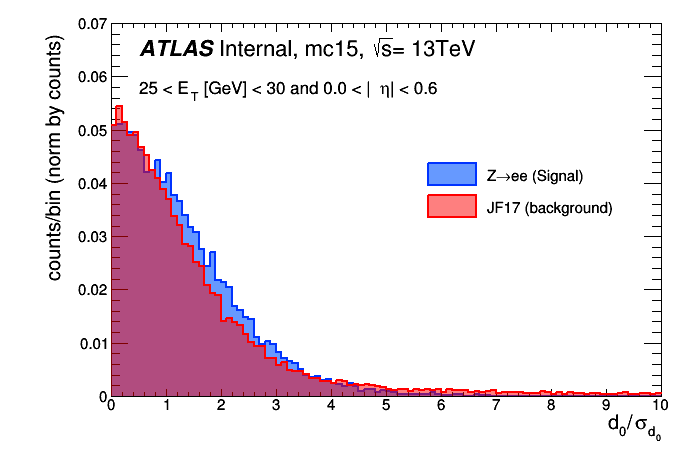

In [247]:
canvas = PlotHist(values['d0significance_sgn'], values['d0significance_bkg'], 'd_{0}/#sigma_{d_{0}}', 100, 0,10,0.07)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.6,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('d0significance_et2_eta0.pdf')

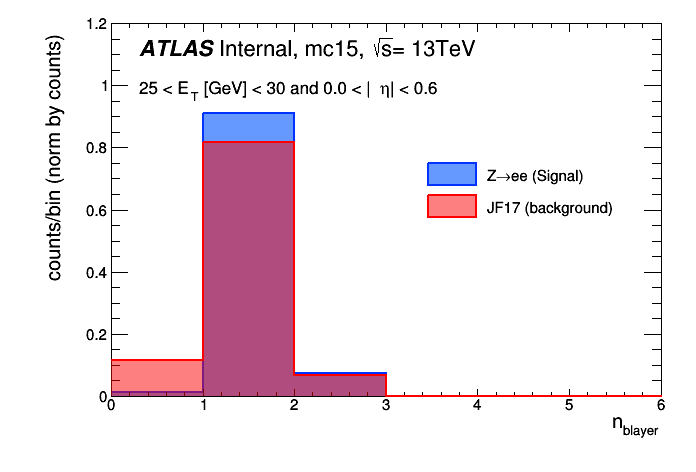

In [251]:
canvas = PlotHist(values['numberOfBLayerHits_sgn'], values['numberOfBLayerHits_bkg'], 
                  'n_{blayer}', 6,0,6, normalize=True, y_axis_maximum=1.2)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.6,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('numberOfBLayerHits_et2_eta0.pdf')

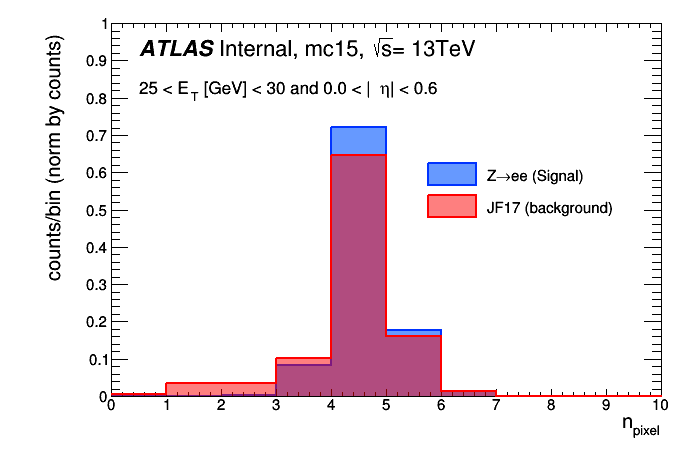

In [252]:
canvas = PlotHist(values['numberOfPixelHits_sgn'], values['numberOfPixelHits_bkg'], 
                  'n_{pixel}', 10,0,10, normalize=True,y_axis_maximum=1.0)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.6,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('numberOfPixelHits_et2_eta0.pdf')

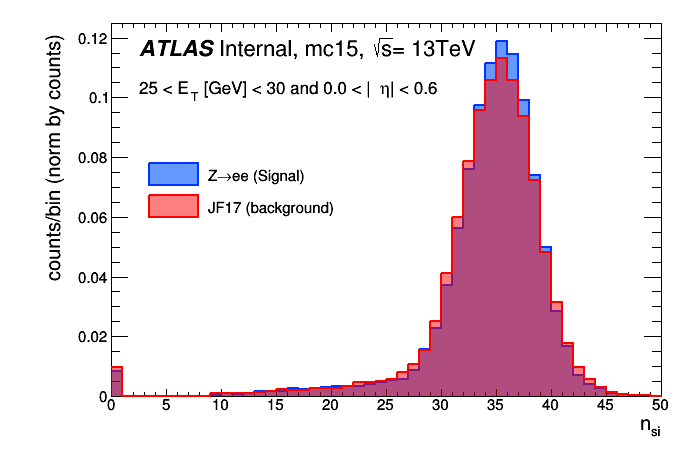

In [253]:
canvas = PlotHist(values['numberOfTRTHits_sgn'], values['numberOfTRTHits_bkg'], 
                  'n_{si}', 50,0,50, normalize=True)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
AddLegend( canvas,0.2,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
AddTexLabel(canvas, 0.2, 0.8, '25 < E_{T} [GeV] < 30 and 0.0 < |#eta| < 0.6', textsize=0.04)
canvas.Draw()
canvas.SaveAs('numberOfTRTHits_et2_eta0.pdf')